#revie experiments

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.insert(1, '/its/home/drs25/Documents/GitHub/Quadruped/Code')
sys.path.insert(1, 'C:/Users/dexte/Documents/GitHub/Quadruped/Code')
from CPG import *
datapath="/its/home/drs25/Documents/GitHub/Quadruped/"
datapath="C:/Users/dexte/Documents/GitHub/Quadruped/"

## load in data

### dt

In [10]:
best_CPGs=[]
fitnesses=[]
trials=2
for _ in range(1,trials+1):
    for dt in np.arange(0.05,1.5,0.05):
        filename = datapath+'/models/genotypes_dt'+str(dt)+"_"+str(_)
        population=None
        with open(filename+'.pkl', 'rb') as f:
            population = pickle.load(f)
        f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
        best_geno=np.argmax(f_)
        best_CPGs=population[best_geno]
        fitnesses.append(np.max(f_))

fitnesses=np.array(fitnesses).reshape(len(np.arange(0.05,1.5,0.05)),trials).T
print(fitnesses.shape)


(2, 29)


#### average dt

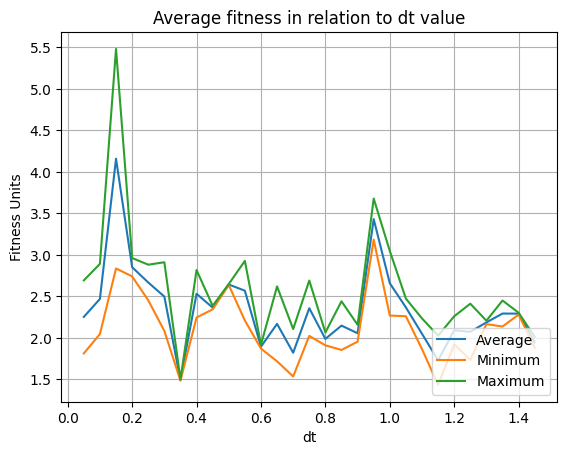

In [12]:
size=len(np.arange(0.05,1.5,0.05))
plt.plot(np.arange(0.05,1.5,0.05),np.average(fitnesses,axis=0),label="Average")
plt.plot(np.arange(0.05,1.5,0.05),np.min(fitnesses,axis=0),label="Minimum")
plt.plot(np.arange(0.05,1.5,0.05),np.max(fitnesses,axis=0),label="Maximum")
plt.xlabel("dt")
plt.ylabel("Fitness Units")
plt.title("Average fitness in relation to dt value")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### trials

(20,) [1.87518805 2.05244644 2.88701113 2.34787167 1.93686972 2.01408603
 3.11433648 1.84133949 1.65930578 5.54943988 2.30737154 2.37057806
 1.61738329 1.81105148 2.2444781  2.55588968 1.91071911 1.91959189
 3.15463089 1.94462   ] (20, 240)


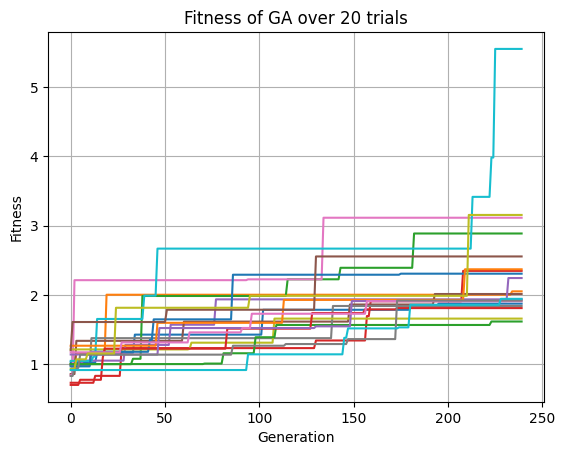

In [12]:
best_CPGs=[]
fitnesses=[]
history=[]
trials=20
dt=0.1
for _ in range(trials):
    filename = datapath+'/models/genotypes_dt'+str(dt)+"_6_neurons_"+str(_)
    population=None
    with open(filename+'.pkl', 'rb') as f:
        population = pickle.load(f)
    f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
    history.append(np.load((filename+'.npy').replace("genotypes","history")))
    best_geno=np.argmax(f_)
    best_CPGs=population[best_geno]
    fitnesses.append(np.max(f_))

fitnesses=np.array(fitnesses).reshape(trials)
history=np.array(history)[:,:-10]
print(fitnesses.shape,fitnesses,history.shape)
plt.plot(history.T)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.grid(True)
plt.show()

#### average trials

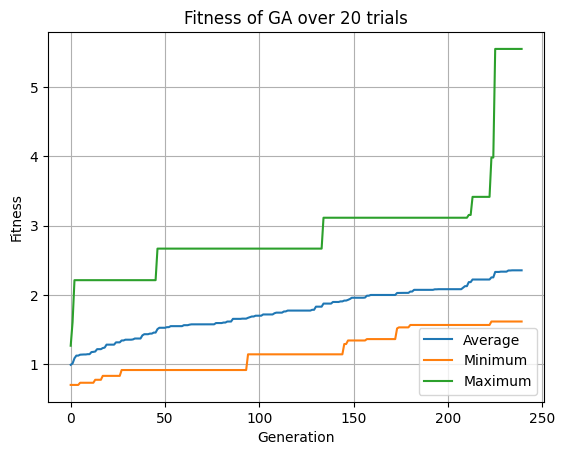

In [10]:

plt.plot(np.average(history,axis=0),label="Average")
plt.plot(np.min(history,axis=0),label="Minimum")
plt.plot(np.max(history,axis=0),label="Maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Display images

(50, 480, 640, 4)


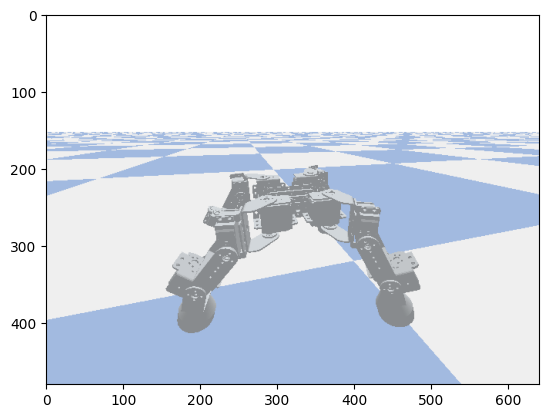

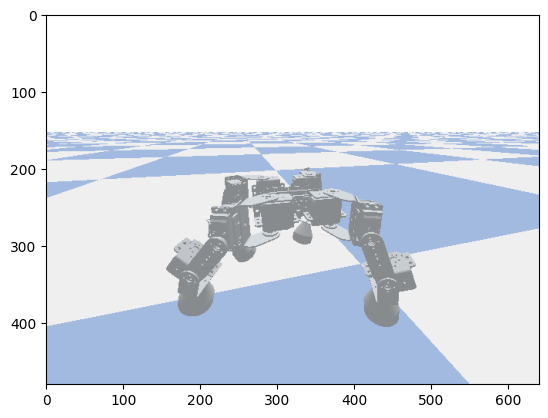

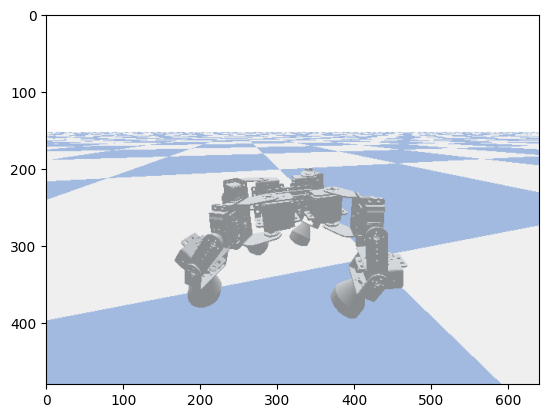

In [5]:
images=np.load(datapath+"/assets/frames.npy")
print(images.shape)
plt.imshow(images[0])
plt.show()
plt.imshow(images[1])
plt.show()
plt.imshow(images[2])
plt.show()

#write function that removes everything but robot